For BUQEYE reviewers: 
* `#xxx` marks places where there are comment lines that might be deleted. Please check (and delete if you know they can be removed).
* `#???` marks questions to be resolved.

# Analysis of Nuclear Matter Results (Refactored)

This notebook reproduces most of the figures in the main text and supplementary material (SM) for _Quantifying uncertainties and correlations in the nuclear-matter equation of state_ by [BUQEYE](https://buqeye.github.io/) members Christian Drischler, Jordan Melendez, Dick Furnstahl, and Daniel Phillips (see [[arXiv:2004.07805]](https://arxiv.org/abs/2004.07805)). 
The results and figures here can be easily modified and extended.

Several other figures for this paper are generated in separate notebooks:
* Figure 1 showing three sets of random functions drawn from three different Gaussian processes is from `../other_figures/gp-draws.ipynb`.
* Figures 13 and 14 showing order-by-order predictions of the pressure and compressibility of symmetric nuclear matter (SNM) for $\Lambda = 500\,$MeV interactions are generated in `./derivatives-bands.ipynb`. 

Related figures in the main text and supplementary material for _How well do we know the neutron-matter equation of state at the densities inside neutron stars? A Bayesian approach with correlated uncertainties_ [[arXiv:2004.07232]](https://arxiv.org/abs/2004.07232) by the same authors are generated in: `./derivatives-bands.ipynb` and `Esym_L/Esym_L_correlation_plot.ipynb`. 
 

This notebook uses modules from standard Python packages, scikit-learn, the BUQEYE gsum package (available with instructions to install at [https://github.com/buqeye/gsum]), and the local nuclear_matter package (**Add installation instructions**). 

#### Table of contents

1. [Import the data](#import_data) 
1. [Define parameters of the analysis](#define_parameters)
1. [Specify the reference scale model(s)](#ref_scale)
1. [Create analysis objects](#analysis_objects)
1. [$\Lambda_b$ and $\ell$ posteriors (Figs. 4 and 5, 20 and 21, and SM 1, 2, 3)](#Lambda_b_and_ell_posteriors)
1. [Pure Neutron Matter (PNM) \[Figures 2, 3, 6, 8a, 15b, 16b, 18 and SM 5a\]](#PNM)
1. [Symmetric Nuclear Matter (SNM)_\[Figures 7, 8b, 9, 15a, 16a, 17, 19 and SM 4, 5b\]](#SNM)
1. [Symmetry Energy \[Figures 10, 11, 12 and SM 6, 7\]](#symmetry_energy)


In [1]:
%load_ext autoreload
%autoreload 2

# Standard Python modules
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
import seaborn as sns
import time

# scikit-learn (https://scikit-learn.org/stable/)
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

import gsum as gm
from nuclear_matter.graphs import add_top_order_legend
from nuclear_matter.stats_utils import *
from nuclear_matter.matter import *
from nuclear_matter import setup_rc_params
from nuclear_matter import InputData

%matplotlib inline

## Set up the defaults for figures

The appearance of figures can be adjusted by changing `setup_rc_params` in `nuclear_matter` or by overriding those choices here. 


In [2]:
#xxx Are these alternatives to be kept or should they be deleted?
# mpl.rcParams['text.usetex'] = True
# mpl.rcParams['figure.dpi'] = 150
# mpl.rcParams['font.family'] = 'serif'
# mpl.rc('savefig', transparent=False, bbox='tight', pad_inches=0.05, format='pdf')
setup_rc_params()

## First, import the data <a id="import_data"></a>

Choices to make here:
* Select $\Lambda = 450$ or $500\,$MeV interactions by setting `Lambda`. (See [[arXiv:2004.07805]](https://arxiv.org/abs/2004.07805) for details.)
* Select low or high density data by setting `high_density` to `False` or `True`.

The calculated nuclear matter data for input is in the `data` directory in csv files.

In [3]:
# Uncomment either Lambda = 450 or 500
# Lambda = 450
Lambda = 500

# Use input data up to low (False) or high density (True)
high_density = True

#$$$ Delete the next two lines?
# filename_low = filename = '../data/all_matter_data.csv'
# filename_high = filename = '../data/all_matter_data_high_density.csv'

#??? Add a comment about smoothing?
filename_low = '../data/all_matter_data.csv'
filename_high = '../data/all_matter_data_high_density_smooth.csv'
# filename_high = '../data/all_matter_data_high_density.csv'
    
# The class InputData is in utils.py.    
data_high_density = InputData(filename_high, Lambda)
data_low_density = InputData(filename_low, Lambda)

if high_density:
    data = data_high_density
else:
    data = data_low_density

#??? Are these dataframe definitions superfluous given InputData? 
#???  Could also refer to make_LaTeX_table.ipynb.
# if high_density:
#     df = pd.read_csv('../data/all_matter_data_high_density.csv')
# else:
#     df = pd.read_csv('../data/all_matter_data.csv')
#     # Convert differences to total prediction at each MBPT order
#     mbpt_orders = ['Kin', 'MBPT_HF', 'MBPT_2', 'MBPT_3', 'MBPT_4']
#     df[mbpt_orders] = df[mbpt_orders].apply(np.cumsum, axis=1)
#     # 'total' is now unnecessary. Remove it.
#     df.pop('total');

In [4]:
#??? Move this to the previous cell?
# The class InputData is in utils.py.    
data_high_density_L450 = InputData(filename_high, 450)
data_high_density_L500 = InputData(filename_high, 500)

In [5]:
#??? Why are there small differences with Table II in posted version? Smoothing?
# Order-by-order [LO, NLO, N2LO, N3LO] energy per nucleon in Mev for SNM (s)
#  for densities from 0.05 to 0.34 fm^{-3}, NN + 3N included. 
data_high_density_L450.y_s_2_plus_3bf

array([[ -7.4020193 ,  -9.11907285,  -8.60611769,  -8.39456754],
       [ -7.93386806,  -9.99870654,  -9.45459217,  -9.23989074],
       [ -8.38201432, -10.8620372 , -10.29617237, -10.02906983],
       [ -8.7811156 , -11.71039681, -11.12893592, -10.77874054],
       [ -9.14902356, -12.54169528, -11.93945957, -11.49189131],
       [ -9.49499133, -13.35325623, -12.70983313, -12.16327247],
       [ -9.82341643, -14.14178658, -13.42007943, -12.7822694 ],
       [-10.13664582, -14.9050945 , -14.05126867, -13.33666295],
       [-10.43596458, -15.64171552, -14.58598388, -13.81398346],
       [-10.72211164, -16.35057902, -15.00858665, -14.20248206],
       [-10.99573224, -17.03123831, -15.30570179, -14.49208683],
       [-11.25751896, -17.68375167, -15.46620108, -14.67474805],
       [-11.50819299, -18.30840152, -15.48108154, -14.74453627],
       [-11.74863914, -18.90593087, -15.34334765, -14.69767944],
       [-11.97957107, -19.47668609, -15.04805448, -14.53253556],
       [-12.20193182, -20

In [6]:
# Make a mask for overlap of low density and high density data 
low_mask = np.isin(data_high_density.density, data_low_density.density)
low_mask

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [7]:
# Order-by-order [LO, NLO, N2LO, N3LO] (PNM - SNM) energy per nucleon (d) in Mev 
#  for densities from 0.05 to 0.34 fm^{-3}, NN + 3N included. 
data_high_density.y_d_2_plus_3bf

array([[15.45696377, 16.05237683, 15.37190602, 15.32139766],
       [16.98420047, 17.59177785, 16.90925383, 16.90879842],
       [18.37702309, 19.06300555, 18.42886915, 18.43411606],
       [19.66711372, 20.46984565, 19.93518533, 19.90714807],
       [20.87646844, 21.81887253, 21.42931533, 21.33645976],
       [22.02072088, 23.11735175, 22.90971566, 22.72878864],
       [23.11190593, 24.37193091, 24.37298265, 24.08909071],
       [24.1586778 , 25.58861819, 25.81400528, 25.42043078],
       [25.16826526, 26.7730166 , 27.22732888, 26.72502641],
       [26.14620531, 27.929621  , 28.60662791, 28.00370648],
       [27.09658818, 29.06201825, 29.94482962, 29.25600433],
       [28.02282813, 30.17328152, 31.23494243, 30.48093681],
       [28.92784839, 31.26595055, 32.47036706, 31.67732814],
       [29.81330876, 32.34167305, 33.6432736 , 32.84234025],
       [30.68112069, 33.40177144, 34.747652  , 33.97430401],
       [31.53221402, 34.44705749, 35.77626475, 35.06998716],
       [32.36749889, 35.

In [8]:
#??? What are we checking here?
for attr in ['y_n_2bf', 'y_s_2bf', 'y_d_2bf', 'y_n_3bf', 'y_s_3bf', 'y_d_3bf',
            'y_n_2_plus_3bf', 'y_s_2_plus_3bf', 'y_d_2_plus_3bf']:
    high_attr = getattr(data_high_density, attr)[low_mask]
    low_attr = getattr(data_low_density, attr)
    attr_close = np.allclose(high_attr, low_attr)
    print(attr, attr_close)
    if not attr_close:
        print(high_attr - low_attr)

y_n_2bf False
[[-0.00991292 -0.01443595 -0.00883209 -0.00511795]
 [ 0.00996971  0.01363293  0.01072946  0.00971779]
 [ 0.01495227  0.019479    0.01148826  0.01027151]
 [ 0.00955604  0.01327123  0.00822692  0.00181367]
 [-0.00133521  0.00278527 -0.00095657 -0.00812463]
 [-0.01281286 -0.00995886 -0.01068124 -0.01507251]
 [-0.01692255 -0.02090595 -0.01595632 -0.01766558]
 [-0.02109574 -0.03085065 -0.02303025 -0.0171865 ]
 [-0.02317852 -0.03037065 -0.0210879  -0.01691921]
 [-0.01600603 -0.02920711 -0.01499857 -0.00703894]
 [-0.00452602 -0.01878159 -0.01111999  0.00342497]
 [ 0.00769311  0.00065033  0.00309788  0.01770039]
 [ 0.0158364   0.0175047   0.02005818  0.03335707]
 [ 0.03925597  0.04163787  0.04339611  0.05815536]
 [ 0.06282709  0.06705121  0.06916647  0.0793989 ]
 [ 0.07868836  0.09669329  0.09619936  0.10786836]
 [ 0.10894648  0.12407966  0.12700852  0.12809332]]
y_s_2bf False
[[-1.68120325e-02 -3.48084010e-03 -1.77235426e-02 -1.52028101e-02]
 [ 1.70472959e-02  2.00970196e-03  2.

## Now define all of the parameters of the analysis <a id="define_parameters"></a>

Here one specifies the orders available (0, 2, 3, 4 are the powers of expansion parameter $Q$ and correspond to chiral EFT orders LO, NLO, N2LO, N3LO) and which powers of $Q$ are excluded in learning the convergence pattern. 

Also specified are where to save figures, the ranges for the hyperparameters $\Lambda_b$ and $\ell$, and the kernel used for the Gaussian process model.

In [9]:
orders = np.array([0, 2, 3, 4])

savefigs = True   # whether or not to save the figures
fig_path = 'manuscript_figures'  # where to save the figures

body2 = 'NN-only'
body23 = 'NN+3N'
body3 = '3N'
body23_appended = 'Appended'

pure_neutron = 'pure'
sym_nuclear = 'sym'
# avg_momentum = 'avg'
s2_energy = 's2'


# excluded = np.array([1])
# excluded_2bf = np.array([1])
excluded = np.array([0, 1])
excluded_2bf = np.array([0, 1])
# excluded = np.array([1, 3])
# excluded_2bf = np.array([1, 3])
excluded_3bf = np.array([0, 1, 2])

# Specify the default breakdown scale \Lambda_b (MeV)
Lb = 600  

# Mesh for breakdown scale
breakdown_min = 250
breakdown_max = 950
breakdown_num = 101
Lb_vals = np.linspace(breakdown_min, breakdown_max, breakdown_num)
Lb_logprior_vals = Lb_logprior(Lb_vals)

# Mesh for length scale
ls_min = 0.15
ls_max = 1.5
ls_num = 95
ls_vals = np.linspace(ls_min, ls_max, ls_num)
#xxx Delete?
# ls_min = ls_max = ls_num = ls_vals = None


# The Gaussian process parameters
nugget = 5e-4   # nugget = 1e-4

# Combining RBF and white noise kernels from scikit-learn
kernel = RBF(length_scale=1, length_scale_bounds=(0.1, 1.5)) + \
    WhiteKernel(noise_level=nugget, noise_level_bounds='fixed')
# kernel1 = RBF(length_scale=1, length_scale_bounds=(1e-2, 100)) + \
#     WhiteKernel(noise_level=nugget, noise_level_bounds='fixed')
kernel_theta = kernel.theta

#??? Is this now obsolete?
ref_2bf = 16

# hyperparams = dict(
#     center=0,
#     disp=0,
#     df=0,
#     scale=1,
# )

#??? Is the comment here still relevant?
df = 10
scale = (df - 2) / df  # Sets expected value to 1

hyperparams = dict(
    center=0,
    disp=0,
    df=df,
    scale=scale,
)

# optimizer = None

In [10]:
#??? What here is still needed?

kf_n = data.kf_n
Kf_n = data.Kf_n
kf_s = data.kf_s
Kf_s = data.Kf_s

# TESTING
# kf_s = kf_n
# Kf_s = Kf_n

kf_d = data.kf_avg
Kf_d = data.Kf_avg

density = data.density

ref_2bf = data.ref_2bf
ref_n_3bf = data.ref_n_3bf
ref_s_3bf = data.ref_s_3bf
ref_d_3bf = data.ref_avg_3bf

y_s_2_plus_3bf = data.y_s_2_plus_3bf
y_n_2_plus_3bf = data.y_n_2_plus_3bf
y_d_2_plus_3bf = data.y_d_2_plus_3bf

y_s_2bf = data.y_s_2bf
y_n_2bf = data.y_n_2bf
y_d_2bf = data.y_d_2bf

y_s_3bf = data.y_s_3bf
y_n_3bf = data.y_n_3bf
y_d_3bf = data.y_d_3bf

fit_n2lo = data.fit_n2lo
fit_n3lo = data.fit_n3lo

In [11]:
density

array([0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11, 0.12, 0.13, 0.14, 0.15,
       0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22, 0.23, 0.24, 0.25, 0.26,
       0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33, 0.34])

In [12]:
sat_idx = density == 0.16

In [13]:
sat_idx

array([False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [14]:
y_n_2_plus_3bf[sat_idx]

array([[18.14623353, 13.28914355, 17.27472416, 16.37425076]])

In [15]:
#xxx Needed?
# plt.plot(kf_n, y_n_2_plus_3bf[:, 0] / (16 * (kf_n / kf0_n)**2))
# plt.ylim(-2, 2)

In [16]:
#xxx Needed?
# y_s_2_plus_3bf[low_mask] = data_low_density.y_s_2_plus_3bf
# y_s_2bf[low_mask] = data_low_density.y_s_2bf
# y_s_3bf[low_mask] = data_low_density.y_s_3bf

In [17]:
if high_density:
#     train = slice(None, None, 5)
#     train = slice(2, None, 5)
#     valid = [(i-2) % 5 == 2 for i in range(len(density))]
    train = slice(1, None, 7)
    valid = [(i-1) % 7 == 4 for i in range(len(density))]
#     valid = slice(4, None, 7)
    
else:
    train = slice(None, None, 4)
    valid = slice(2, None, 4)

In [18]:
#??? Is any of this still needed given MatterConvergenceAnalysis?

# orders = np.array([0, 2, 3, 4])
# # body = 'NN-only'
# # body = 'NN+3N'
# Lambda = 450
# fits = {450: [1, 7], 500: [4, 10]}
# train1 = slice(None, None, 5)
# valid1 = slice(2, None, 5)
# # valid1 = np.array([i % 5 != 0 for i in range(len())])
# [fit_n2lo, fit_n3lo] = fits[Lambda]

# excluded = np.array([0, 1])

# savefigs = False

# Lb = 600

# breakdown_min = 300
# breakdown_max = 1000
# breakdown_num = 100
# Lb_vals = np.linspace(breakdown_min, breakdown_max, breakdown_num)
# Lb_logprior_vals = Lb_logprior(Lb_vals)

# ls_min = 0.1
# ls_max = 1.5
# ls_num = 50
# ls_vals = np.linspace(ls_min, ls_max, ls_num)
# # ls_min = ls_max = ls_num = ls_vals = None

# nugget = 1e-8

# kernel1 = RBF(length_scale=1, length_scale_bounds=(5e-2, 4)) + \
#     WhiteKernel(noise_level=nugget, noise_level_bounds='fixed')
# # kernel1 = RBF(length_scale=1, length_scale_bounds=(1e-2, 100)) + \
# #     WhiteKernel(noise_level=nugget, noise_level_bounds='fixed')
# kernel1_theta = kernel1.theta
# ref1 = 16

# hyperparams = dict(
#     center=0,
#     disp=0,
# #     df=1,
# #     scale=1
#     sd=2
# )


# mask_fit = np.isin(df['fit'], fits[Lambda]) | np.isnan(df['fit'])

# mask1 = \
# #     (df['Body'] == body) & \
#     mask_fit & \
#     (df['Lambda'] == Lambda)


# # df_fit = df[mask_fit]
# df_n = df[mask1 & (df['x'] == 0)]
# df_s = df[mask1 & (df['x'] == 0.5)]

# kf_n = df_n[(df_n['OrderEFT'] == 'LO') & (df_n['Body'] == 'NN-only')]['kf'].values
# kf_s = df_s[(df_s['OrderEFT'] == 'LO') & (df_s['Body'] == 'NN-only')]['kf'].values
# density = df_n[(df_n['OrderEFT'] == 'LO') & (df_n['Body'] == 'NN-only')]['n'].values
# kf_d = kf_n.copy()

# # valid1 = np.arange(len(kf_n)) % 5 != 0

# Kf_n = kf_n[:, None]
# Kf_s = kf_s[:, None]
# Kf_d = kf_d[:, None]

# kf_s_dense = np.linspace(kf_s.min(), kf_s.max(), 100)
# Kf_s_dense = kf_s_dense[:, None]

# if not high_density:
#     kf_n_dense = np.linspace(kf_n.min(), kf_n.max(), 100)
#     Kf_n_dense = kf_n_dense[:, None]

#     kf_d_dense = np.linspace(kf_d.min(), kf_d.max(), 100)
#     Kf_d_dense = kf_d_dense[:, None]

#     y1_n = np.array([df_n[df_n['OrderEFT'] == order]['MBPT_4'].values for order in df_n['OrderEFT'].unique()]).T
#     y1_s = np.array([df_s[df_s['OrderEFT'] == order]['MBPT_4'].values for order in df_s['OrderEFT'].unique()]).T
#     y1_d = y1_n - y1_s
# else:
#     y1_s = np.array([df_s[df_s['OrderEFT'] == order]['MBPT_4'].values for order in df_s['OrderEFT'].unique()]).T

## Specify the reference scale models <a id="ref_scale"></a>

The default reference scale model here is used for figures outside of the appendices and is given by Eq.(9) and surrounding discussion.
An alternative model, specified in Eq.(A1) and surrounding text, can be invoked by uncommenting below.

The default is to treat NN and 3N together. This is set in [Create analysis objects](#analysis_objects) with `n_body = body23`. To treat NN and 3N separately, set `n_body = body23_appended`.

In [19]:
#??? Any reason to not move to the top?
from functools import partial

In [20]:
def ref_cubic(X, scale=1):
    """Compute 16 kf^3 for any kf prescription"""
    return 16 * (X.ravel() / scale) ** 3

def ref_quadratic(X, scale=1):
    """Compute 16 kf^3 for any kf prescription"""
    return 16 * (X.ravel() / scale) ** 2

def ref_linear(X, scale=1):
    """Compute 16 kf^3 for any kf prescription"""
    return 16 * (X.ravel() / scale)

#xxx Delete some of these?
# ref_2bf_func = ref_cubic
# ref_2bf_func = ref_linear
# ref_2bf_func = ref_quadratic
# ref_3bf_func = ref_linear
# ref_3bf_func = ref_quadratic
# ref_3bf_func = ref_cubic

# kf0_n = fermi_momentum(0.16, 2)
# kf0_s = fermi_momentum(0.16, 4)
# kf0_d = fermi_momentum(0.16, 3)

kf0_n = kf_n[density == 0.16]
kf0_s = kf_s[density == 0.16]

# Reference scale model in Eq.(9).
ref_2bf_func_n = partial(ref_quadratic, scale=kf0_n)
ref_2bf_func_s = partial(ref_quadratic, scale=kf0_s#/np.sqrt(2)
                        )
ref_2bf_func_d = partial(ref_quadratic, scale=kf0_n)
# ref_2bf_func_n = 16
# ref_2bf_func_s = 16
# ref_2bf_func_d = 16

ref_3bf_func_n = partial(ref_quadratic, scale=1)
ref_3bf_func_s = partial(ref_quadratic, scale=1/np.sqrt(1.2))
ref_3bf_func_d = partial(ref_quadratic, scale=1)

# Uncomment these for alternative reference scale model in Eq.(A1).
# ref_2bf_func_n = partial(ref_const, scale=1)
# ref_2bf_func_s = partial(ref_const, scale=1)
# ref_2bf_func_d = partial(ref_const, scale=1)
# ref_3bf_func_n = partial(ref_cubic, scale=1)
# ref_3bf_func_s = partial(ref_cubic, scale=1)
# ref_3bf_func_d = partial(ref_cubic, scale=1)

In [21]:
kf0_n**2

array([2.82072025])

In [22]:
kf0_s

array([1.33302])

## Create analysis objects <a id="analysis_objects"></a>

These analysis objects will contain all the observable-specific info and know how to make various plots.
The plots will save with informative image names and avoid a cluttered namespace. As we start varying more parameters, we must make sure that each important variable is reflected in the figure names, so that we don't overwrite images.

The default is to treat NN and 3N together. This is set below with `n_body = body23`. To treat NN and 3N separately, set `n_body = body23_appended`.

In [23]:
y_s_2bf.shape

(30, 4)

In [24]:
#??? Is this still relevant?
# if high_density:
#     n_body = body23
#     analysis_s = MatterConvergenceAnalysis(
#         X=Kf_s, y2=y_s_2bf, y3=y_s_2_plus_3bf, orders=orders, train=train, valid=valid,
#         ref2=ref_2bf, ref3=ref_3bf_func, ratio='kf', density=density,
#         kernel=kernel, system='symmetric', fit_n2lo=fit_n2lo, fit_n3lo=fit_n3lo, Lambda=Lambda,
#         body=n_body, savefigs=savefigs, excluded=excluded, **hyperparams
#     )
# else:
#     n_body = body23_appended
    
#     analysis_s = MatterConvergenceAnalysis(
#         X=Kf_s, y2=y_s_2bf, y3=y_s_2_plus_3bf, orders=orders, train=train, valid=valid,
#         ref2=ref_2bf, ref3=ref_3bf_func,  ratio='kf', density=density,
#         kernel=kernel, system='symmetric', fit_n2lo=fit_n2lo, fit_n3lo=fit_n3lo, Lambda=Lambda,
#         body=n_body, savefigs=savefigs, excluded=excluded, **hyperparams
#     )
#     analysis_n = MatterConvergenceAnalysis(
#         X=Kf_n, y2=y_n_2bf, y3=y_n_2_plus_3bf, orders=orders, train=train, valid=valid,
#         ref2=ref_2bf, ref3=ref_3bf_func, ratio='kf', density=density,
#         kernel=kernel, system='neutron', fit_n2lo=fit_n2lo, fit_n3lo=fit_n3lo, Lambda=Lambda,
#         body=n_body, savefigs=savefigs, excluded=excluded, **hyperparams
#     )
#     analysis_d = MatterConvergenceAnalysis(
#         X=Kf_d, y2=y_d_2bf, y3=y_d_2_plus_3bf, orders=orders, train=train, valid=valid,
#         ref2=ref_2bf, ref3=ref_3bf_func, ratio='kf', density=density,
#         kernel=kernel, system='difference', fit_n2lo=fit_n2lo, fit_n3lo=fit_n3lo, Lambda=Lambda,
#         body=n_body, savefigs=savefigs, excluded=excluded, **hyperparams
#     )

# n_body = body23_appended 
n_body = body23

# s, n, d refer to SNM, PNM, and the difference
analysis_s = MatterConvergenceAnalysis(
    X=Kf_s, y2=y_s_2bf, y3=y_s_2_plus_3bf, orders=orders, train=train, valid=valid,
    ref2=ref_2bf_func_s, ref3=ref_3bf_func_s,  ratio='kf', density=density,
    kernel=kernel, system='symmetric', fit_n2lo=fit_n2lo, fit_n3lo=fit_n3lo, Lambda=Lambda,
    body=n_body, savefigs=savefigs, excluded=excluded, fig_path=fig_path, **hyperparams
)
analysis_n = MatterConvergenceAnalysis(
    X=Kf_n, y2=y_n_2bf, y3=y_n_2_plus_3bf, orders=orders, train=train, valid=valid,
    ref2=ref_2bf_func_n, ref3=ref_3bf_func_n, ratio='kf', density=density,
    kernel=kernel, system='neutron', fit_n2lo=fit_n2lo, fit_n3lo=fit_n3lo, Lambda=Lambda,
    body=n_body, savefigs=savefigs, excluded=excluded, fig_path=fig_path, **hyperparams
)
analysis_d = MatterConvergenceAnalysis(
    X=Kf_d, y2=y_d_2bf, y3=y_d_2_plus_3bf, orders=orders, train=train, valid=valid,
    ref2=ref_2bf_func_d, ref3=ref_3bf_func_d, ratio='kf', density=density,
    kernel=kernel, system='difference', fit_n2lo=fit_n2lo, fit_n3lo=fit_n3lo, Lambda=Lambda,
    body=n_body, savefigs=savefigs, excluded=excluded, fig_path=fig_path, **hyperparams
)

In [25]:
#xxx Add comment or delete (also next two cells)
# fig = analysis_n.plot_credible_diagnostic(breakdown=600)

In [26]:
# analysis_s.plot_coefficients(breakdown=Lb)

In [27]:
# assert False

Can take a while if a large breakdown/ls grid is used

In [28]:
# Prior for breakdown scales is normal with mean 600 and width 150 MeV. 
breakdown_vals = np.linspace(breakdown_min, breakdown_max, breakdown_num)
breakdown_prior = stats.norm(600, scale=150).pdf(breakdown_vals)

# Prior for length scale \ell is uniform.
ls_prior = 1 / np.linspace(ls_min, ls_max, ls_num)

logprior = np.log(ls_prior[:, None] * breakdown_prior)
# logprior = None

In [29]:
breakdown_vals

array([250., 257., 264., 271., 278., 285., 292., 299., 306., 313., 320.,
       327., 334., 341., 348., 355., 362., 369., 376., 383., 390., 397.,
       404., 411., 418., 425., 432., 439., 446., 453., 460., 467., 474.,
       481., 488., 495., 502., 509., 516., 523., 530., 537., 544., 551.,
       558., 565., 572., 579., 586., 593., 600., 607., 614., 621., 628.,
       635., 642., 649., 656., 663., 670., 677., 684., 691., 698., 705.,
       712., 719., 726., 733., 740., 747., 754., 761., 768., 775., 782.,
       789., 796., 803., 810., 817., 824., 831., 838., 845., 852., 859.,
       866., 873., 880., 887., 894., 901., 908., 915., 922., 929., 936.,
       943., 950.])

In [30]:
if n_body == body23_appended:
    max_idxs = [3, 5]
    max_idx_labels = [2, 3]
else:
    max_idxs = [2, 3]
    max_idx_labels = None

t_start = time.time()
# if high_density:
#     analysis_s.setup_posteriors(
#         breakdown_min=breakdown_min, breakdown_max=breakdown_max, breakdown_num=breakdown_num,
#         ls_min=ls_min, ls_max=ls_max, ls_num=ls_num,
#         max_idx=max_idxs, max_idx_labels=max_idx_labels, logprior=None
#     )
# else:
#     analysis_s.setup_posteriors(
#         breakdown_min=breakdown_min, breakdown_max=breakdown_max, breakdown_num=breakdown_num,
#         ls_min=ls_min, ls_max=ls_max, ls_num=ls_num,
#         max_idx=max_idxs, max_idx_labels=max_idx_labels, logprior=None
#     )
#     analysis_n.setup_posteriors(
#         breakdown_min=breakdown_min, breakdown_max=breakdown_max, breakdown_num=breakdown_num,
#         ls_min=ls_min, ls_max=ls_max, ls_num=ls_num,
#         max_idx=max_idxs, max_idx_labels=max_idx_labels, logprior=None
#     )
#     analysis_d.setup_posteriors(
#         breakdown_min=breakdown_min, breakdown_max=breakdown_max, breakdown_num=breakdown_num,
#         ls_min=ls_min, ls_max=ls_max, ls_num=ls_num,
#         max_idx=max_idxs, max_idx_labels=max_idx_labels, logprior=None
#     )

analysis_s.setup_posteriors(
    breakdown_min=breakdown_min, breakdown_max=breakdown_max, breakdown_num=breakdown_num,
    ls_min=ls_min, ls_max=ls_max, ls_num=ls_num,
    max_idx=max_idxs, max_idx_labels=max_idx_labels, logprior=logprior
)
analysis_n.setup_posteriors(
    breakdown_min=breakdown_min, breakdown_max=breakdown_max, breakdown_num=breakdown_num,
    ls_min=ls_min, ls_max=ls_max, ls_num=ls_num,
    max_idx=max_idxs, max_idx_labels=max_idx_labels, logprior=logprior
)
analysis_d.setup_posteriors(
    breakdown_min=breakdown_min, breakdown_max=breakdown_max, breakdown_num=breakdown_num,
    ls_min=ls_min, ls_max=ls_max, ls_num=ls_num,
    max_idx=max_idxs, max_idx_labels=max_idx_labels, logprior=logprior
)

print(time.time() - t_start)

24.75145697593689


## $\Lambda_b$ and $\ell$ posteriors (Figures 4 and 5, 20 and 21, SM 1 and 2) <a id="Lambda_b_and_ell_posteriors"></a> 

These posteriors are generated for the current value of Lambda (450 or 500) using the current model for the reference scale. Figures 4 and 5 have Lambda = 500 while SM Figs. 1 and 2 have Lambda = 450, also using the reference scale in Eq.(9). Figures 20 and 21 use the alternative model specified in Eq.(A1) and nearby text. 
Figures showing joint posteriors for PNM, SNM, and the symmetry energy are also generated (not included in the publication).

Create a DataFrame that holds the $\Lambda_b$ pdf for all observables put together. Assume they are independent, so they multiply. Also, we assumed a constant prior above, so we don't need to worry about accidentally overcounting it.

In [31]:
df_Lb_pdf_all = analysis_n.df_breakdown.copy()
df_Lb_pdf_all['pdf'] = analysis_n.df_breakdown['pdf'] * analysis_s.df_breakdown['pdf'] * analysis_d.df_breakdown['pdf']
df_Lb_pdf_all.loc[df_Lb_pdf_all['Order'] == r'N$^2$LO', 'pdf'] /= breakdown_prior ** 2. # Don't overcount
df_Lb_pdf_all.loc[df_Lb_pdf_all['Order'] == r'N$^3$LO', 'pdf'] /= breakdown_prior ** 2. # Don't overcount
df_Lb_pdf_all['system'] = 'All'

df_Lb_pdf_ns = analysis_n.df_breakdown.copy()
df_Lb_pdf_ns['pdf'] = analysis_n.df_breakdown['pdf'] * analysis_s.df_breakdown['pdf']
# df_Lb_pdf_ns['pdf'] /= breakdown_prior ** 1. # Don't overcount
df_Lb_pdf_ns.loc[df_Lb_pdf_ns['Order'] == r'N$^2$LO', 'pdf'] /= breakdown_prior ** 1. # Don't overcount
df_Lb_pdf_ns.loc[df_Lb_pdf_ns['Order'] == r'N$^3$LO', 'pdf'] /= breakdown_prior ** 1. # Don't overcount
df_Lb_pdf_ns['system'] = 'All'


In [32]:
def dict_to_str(d):
    s = ''
    for key, value in d.items():
        s += f'{key}-{value}_'
    s = s.replace('.', 'p')
    return s[:-1]

Create the plot of all their pdfs

In [33]:
#xxx Still relevant?

# fig, ax = plt.subplots(figsize=(3.4, 4.4))
# df_Lb_pdf_with_S2 = pd.concat([analysis_n.df_breakdown, analysis_s.df_breakdown, analysis_d.df_breakdown, df_Lb_pdf_all])
# ax = pdfplot(
#     x=r'$\Lambda_b$ [MeV]', y='system', pdf='pdf', data=df_Lb_pdf_with_S2, hue='Order',
#     order=[r'$E/N$', r'$E/A$', r'$S_2$', 'All'], hue_order=[r'N$^2$LO', r'N$^3$LO'], cut=1e-2, linewidth=1,
#         palette="coolwarm", saturation=1., ax=ax, margin=0.3,
# )
# ax.set_xlim(0, 1200)
# ax.set_xticks([0, 300, 600, 900, 1200])
# ax.grid(axis='x')
# ax.set_axisbelow(True)
# fig = plt.gcf()
# if savefigs:
#     fig.savefig(
#         analysis_n.figure_name(
#             'Lb_pdfs_with-S2_', breakdown=(breakdown_min, breakdown_max, breakdown_num), include_system=False,
#             ls=(ls_min, ls_max, ls_num),
#         )
#     )

In [34]:
def scale_lb(df):
    df = df.copy()
    df[r'pdf'] = df[r'pdf'] * breakdown_prior
    df[r'pdf'] /= np.trapz(df[r'pdf'], df[r'$\Lambda_b$ [MeV]'])
    return df

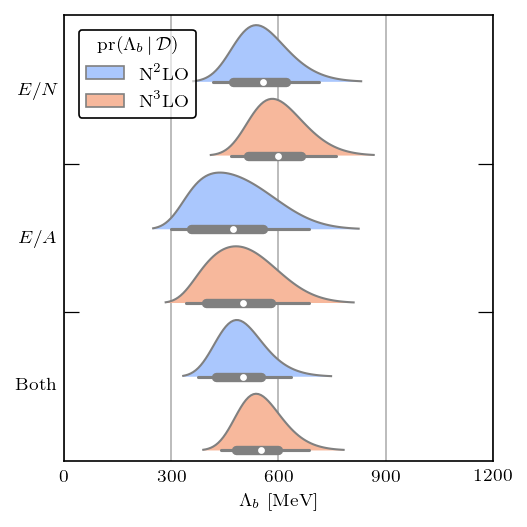

In [35]:
# Generate Figure 4: \Lambda_b posterior (also Figure 20 and SM 1)

fig, ax = plt.subplots(figsize=(3.4, 3.4))
df_Lb_pdf = pd.concat([analysis_n.df_breakdown, analysis_s.df_breakdown, df_Lb_pdf_ns])
df_Lb_pdf = df_Lb_pdf.groupby(['system', 'Order']).apply(scale_lb)

ax.margins(y=0.025)
ax = pdfplot(
    x=r'$\Lambda_b$ [MeV]', y='system', pdf='pdf', data=df_Lb_pdf, hue='Order',
    order=[r'$E/N$', r'$E/A$', 'All'], hue_order=[r'N$^2$LO', r'N$^3$LO'], cut=1e-2, linewidth=1,
    palette="coolwarm", saturation=1., ax=ax,
    margin=0.3,
    legend_title=r'pr($\Lambda_b \,|\, \mathcal{D}$)', loc='upper left'
)

ax.set_xlim(0, 1200)
ax.set_xticks([0, 300, 600, 900, 1200])
ax.grid(axis='x')
ax.set_axisbelow(True)
# ax.text(
#     0.035, 0.95, r'pr($\Lambda_b \,|\, \mathcal{D}$)',
#     transform=ax.transAxes,
#     ha='left', va='top', bbox=dict(boxstyle='round', facecolor='w')
# )
# ax.legend(*ax.get_legend_handles_labels(), title=)
# ax.set_yticklabels([r'$\displaystyle\frac{E}{N}$', r'$\displaystyle\frac{E}{A}$', 'Both'])
ax.set_yticklabels([r'$E/N$', r'$E/A$', 'Both'])
plt.show()
if savefigs:
    fig.savefig(
        analysis_n.figure_name(
            'Lb_pdfs_', breakdown=(breakdown_min, breakdown_max, breakdown_num), include_system=False,
            ls=(ls_min, ls_max, ls_num),
        )
    )

In [36]:
lb_max_mask = \
    (df_Lb_pdf['Body'] == n_body) & \
    (df_Lb_pdf['system'] == 'All') & \
    (df_Lb_pdf['Order'] == 'N$^3$LO')
lb_max_idx = df_Lb_pdf[lb_max_mask]['pdf'].idxmax()
lb_map = df_Lb_pdf[lb_max_mask].loc[lb_max_idx]['$\Lambda_b$ [MeV]']
lb_map

537.0

In [37]:
lb_median = compute_pdf_median_and_bounds(
    df_Lb_pdf[lb_max_mask]['$\Lambda_b$ [MeV]'], df_Lb_pdf[lb_max_mask]['pdf'], [0.95]
)[0]

In [38]:
lb_median

551.0

In [39]:
450 * np.sqrt(2)

636.3961030678928

Now one for the marginal length scale pdfs. A common length scale for all observables probably isn't necessary, so don't compute an "All" pdf.

In [40]:
#??? Still relevant?

# df_ls_pdf = pd.concat([analysis_n.df_ls, analysis_s.df_ls, analysis_d.df_ls])
# ax = pdfplot(
#     x=r'$\ell$ [fm$^{-1}$]', y='system', pdf='pdf', data=df_ls_pdf, hue='Order',
#     order=[r'$E/N$', r'$E/A$', r'$S_2$'], hue_order=[r'N$^2$LO', r'N$^3$LO'], cut=1e-2, linewidth=1.,
#         palette="coolwarm", saturation=1., ax=None, margin=0.3,
# )
# ax.set_xticks([0, 0.25, 0.5, 0.75, 1., 1.25, 1.5]);
# ax.set_xlim(0, 1.2)
# ax.grid(axis='x');
# ax.set_axisbelow(True)
# fig = plt.gcf()
# # ax.xaxis.set_minor_locator(AutoMinorLocator(2))
# if savefigs:
#     fig.savefig(
#         analysis_n.figure_name(
#             'ls_pdfs_with_S2_', breakdown=(breakdown_min, breakdown_max, breakdown_num), include_system=False,
#             ls=(ls_min, ls_max, ls_num),
#         )
#     )

In [41]:
df_n_ls_map = analysis_n.df_joint[analysis_n.df_joint['$\Lambda_b$ [MeV]'] == lb_map]
df_s_ls_map = analysis_s.df_joint[analysis_s.df_joint['$\Lambda_b$ [MeV]'] == lb_map]

In [42]:
df_s_ls_map

,$\ell$ [fm$^{-1}$],$\Lambda_b$ [MeV],pdf,Order,Order Index,system,Body
41,0.150000,537.0,1.064049e-04,N$^2$LO,2,$E/A$,NN+3N
142,0.164362,537.0,1.733922e-04,N$^2$LO,2,$E/A$,NN+3N
243,0.178723,537.0,2.807781e-04,N$^2$LO,2,$E/A$,NN+3N
344,0.193085,537.0,4.505820e-04,N$^2$LO,2,$E/A$,NN+3N
445,0.207447,537.0,7.158332e-04,N$^2$LO,2,$E/A$,NN+3N
...,...,...,...,...,...,...,...
18726,1.442553,537.0,1.338205e-06,N$^3$LO,3,$E/A$,NN+3N
18827,1.456915,537.0,1.149149e-06,N$^3$LO,3,$E/A$,NN+3N
18928,1.471277,537.0,9.893418e-07,N$^3$LO,3,$E/A$,NN+3N
19029,1.485638,537.0,8.539351e-07,N$^3$LO,3,$E/A$,NN+3N


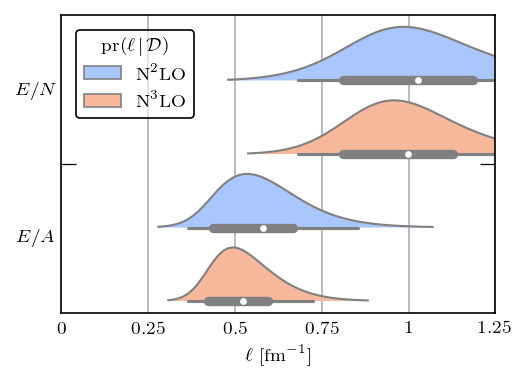

In [43]:
# Generate Figure 5: \ell posterior (also Figures 21 and SM 2)

fig, ax = plt.subplots(figsize=(3.4, 2.425))
df_ls_pdf = pd.concat([analysis_n.df_ls, analysis_s.df_ls])
# df_ls_pdf = pd.concat([df_n_ls_map, df_s_ls_map])

ax.margins(y=0.044)
ax = pdfplot(
    x=r'$\ell$ [fm$^{-1}$]', y='system', pdf='pdf', data=df_ls_pdf, hue='Order',
    order=[r'$E/N$', r'$E/A$'], hue_order=[r'N$^2$LO', r'N$^3$LO'], cut=1e-2, linewidth=1.,
        palette="coolwarm", saturation=1., ax=ax, margin=0.37, legend_title=r'pr($\ell \,|\, \mathcal{D}$)',
    loc='upper left'
)
ax.set_xticks([0, 0.25, 0.5, 0.75, 1., 1.25]);
# ax.set_xticklabels(['0', '1/4', '1/2', '3/4', '1', '5/4'])
ax.set_xticklabels([0, 0.25, 0.5, 0.75, 1, 1.25])
ax.set_xlim(0, 1.25)
ax.grid(axis='x');
ax.set_axisbelow(True)

if savefigs:
    fig.savefig(
        analysis_n.figure_name(
            'ls_pdfs_', breakdown=(breakdown_min, breakdown_max, breakdown_num), include_system=False,
            ls=(ls_min, ls_max, ls_num),
        )
    )

/Users/furnstah/Dropbox/git_rjf/Drischler_projects/nuclear-matter-convergence/nuclear_matter/stats_utils.py:147: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout(h_pad=0, w_pad=0)


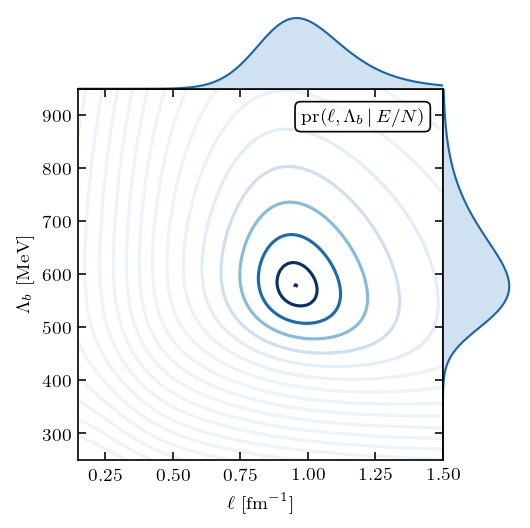

In [44]:
# joint posterior for PNM
fig = analysis_n.plot_joint_breakdown_ls(max_idx=3)

/Users/furnstah/Dropbox/git_rjf/Drischler_projects/nuclear-matter-convergence/nuclear_matter/stats_utils.py:147: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout(h_pad=0, w_pad=0)


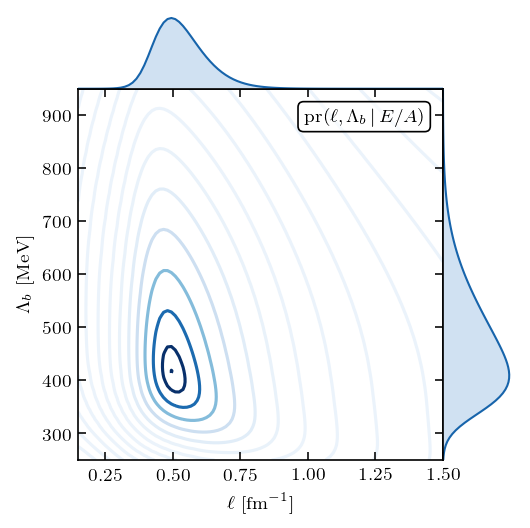

In [45]:
# joint posterior for SNM

fig = analysis_s.plot_joint_breakdown_ls(max_idx=3)

/Users/furnstah/Dropbox/git_rjf/Drischler_projects/nuclear-matter-convergence/nuclear_matter/stats_utils.py:147: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout(h_pad=0, w_pad=0)


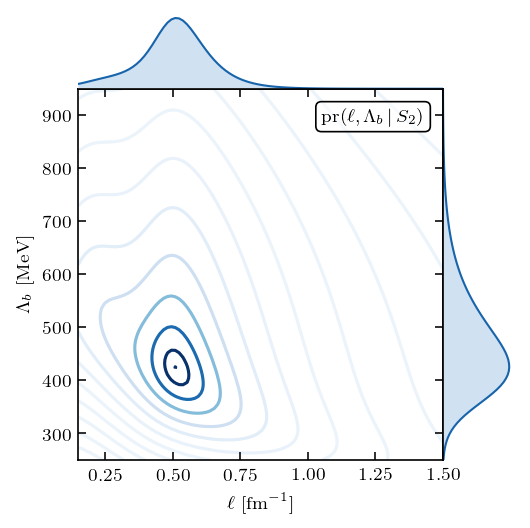

In [46]:
# joint posterior for symmetry energy

fig = analysis_d.plot_joint_breakdown_ls(max_idx=2)

## Pure Neutron Matter (PNM) \[Figures 2, 3, 6, 8a, 15b, 16b, 18 and SM 5a\]  <a id="PNM"></a> 

These figures include the coefficient functions, the MD and PC diagnostics, and order-by-order energy per neutron (E/N).

In [47]:
kernel_n_test = RBF(1.1, 'fixed') + WhiteKernel(0.001, 'fixed')

In [48]:
# fig = analysis_n.plot_coeff_diagnostics(breakdown=Lb, interp=False, kernel=kernel_n_test, show_excluded=True)

RBF(length_scale=0.973) + WhiteKernel(noise_level=0.0005)
cbar mean: 1.0013486060408017


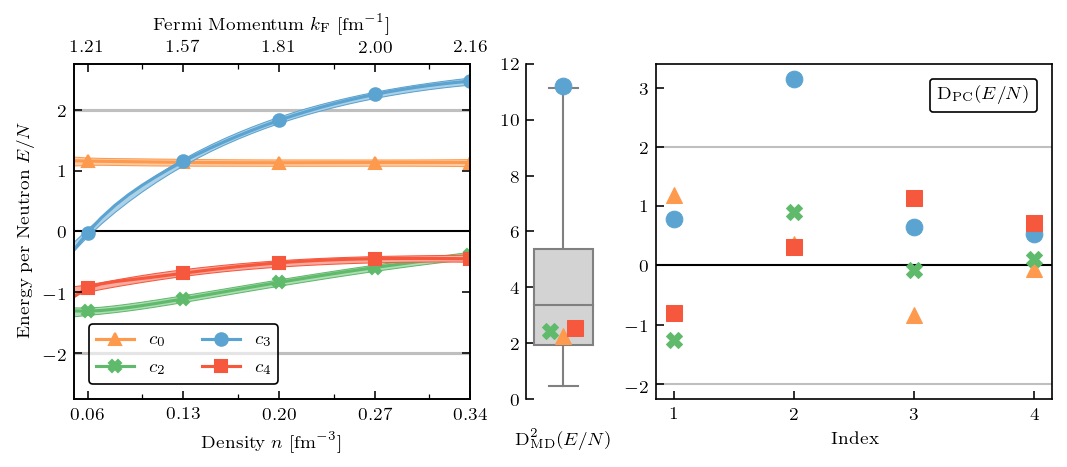

In [49]:
# Generate Figure 2 [separate coefficients below] (also figures 15b, ...)

fig = plt.figure(figsize=(7, 3))
fig = analysis_n.plot_coeff_diagnostics(
    breakdown=Lb, interp=False, show_excluded=True, fig=fig,
#     kernel=RBF(length_scale=0.763) + WhiteKernel(1e-4, 'fixed')
)

In [50]:
# fig = analysis_n.plot_coeff_diagnostics(breakdown=Lb, interp=False)

In [51]:
# fig = analysis_n.plot_coeff_diagnostics(breakdown=Lb, interp=True)

In [52]:
analysis_n.n_bodies

[None, None, None, None]

[0 2 3 4]


/Users/furnstah/anaconda3/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


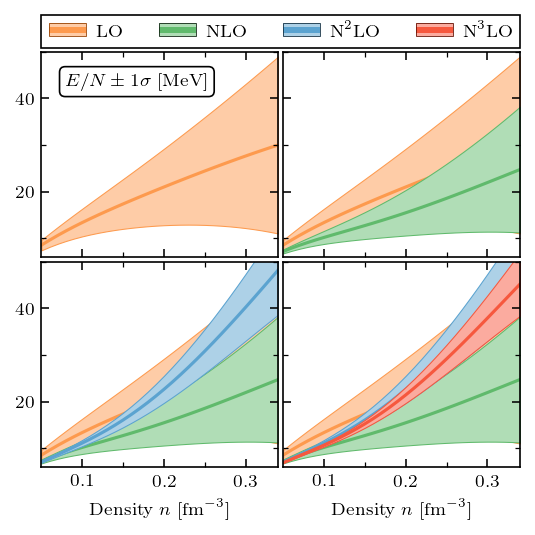

In [53]:
# Generate Figure 6 (also figures )

fig, axes = plt.subplots(2, 2, figsize=(3.4, 3.4), sharex=True, sharey='row')
fig.set_constrained_layout_pads(h_pad=1.1/72, w_pad=1.2/72)
obs_label = r"""$E/N \pm 1\sigma$ [MeV]"""
axes[0,0].text(
    0.1, 0.9, obs_label, transform=axes[0,0].transAxes, ha='left', va='top',
    bbox=dict(boxstyle='round', facecolor='w')
)
axes[0, 0].set_ylim(6, 50)  # Don't show 0 in the top plots, it gets in the way
axes[1, 0].set_ylim(6, 50)
for ax in axes.ravel():
    ax.yaxis.set_major_locator(MultipleLocator(20))
analysis_n.plot_observables(breakdown=Lb, show_process=True, show_excluded=True, ax=axes, panels=True)
plt.show()

In [54]:
# fig = analysis_n.plot_coeff_diagnostics(breakdown=None, interp=False)

In [55]:
# fig = analysis_n.plot_coeff_diagnostics(breakdown=lb_map)

There's clearly some noise below, we should include it in the kernel. Discuss with Christian about the precision of his calculations.

RBF(length_scale=0.973) + WhiteKernel(noise_level=0.0005)
cbar mean: 1.0013486060408017


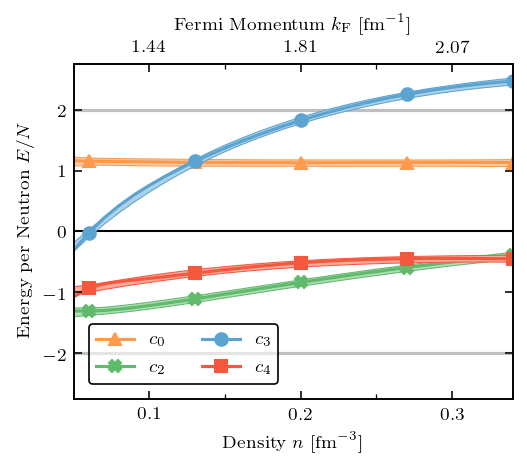

In [56]:
# Generate Figure 2 

fig, ax = plt.subplots(1, 1, figsize=(3.4, 3))
analysis_n.plot_coefficients(
    breakdown=Lb, show_process=True, show_excluded=True, ax=ax, show_train_valid=False,
    loc='lower left'
);

## Symmetric Nuclear Matter (SNM)_\[Figures 7, 8b, 9, 15a, 16a, 17, 19 and SM 4, 5b\] <a id="SNM"></a> 

These figures include the coefficient functions, the MD and PC and credible interval diagnostics, order-by-order energy per nucleon, and saturation ellipses. 

RBF(length_scale=0.485) + WhiteKernel(noise_level=0.0005)
cbar mean: 2.9476905416196773


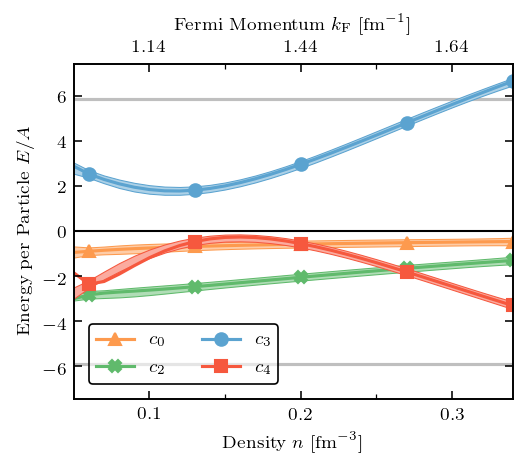

In [57]:
# Generate Figure 3 (also figures ...)
fig, ax = plt.subplots(1, 1, figsize=(3.4, 3))
analysis_s.plot_coefficients(
    breakdown=Lb, show_process=True, show_excluded=True, show_train_valid=False,
    loc='lower left', ax=ax
);

In [58]:
kernel

RBF(length_scale=1) + WhiteKernel(noise_level=0.0005)

In [59]:
kernel_s_test = RBF(0.2, 'fixed') + WhiteKernel(0.001, 'fixed')

In [60]:
# fig = analysis_s.plot_coeff_diagnostics(breakdown=Lb, kernel=kernel_s_test)

RBF(length_scale=0.485) + WhiteKernel(noise_level=0.0005)
cbar mean: 2.9476905416196773


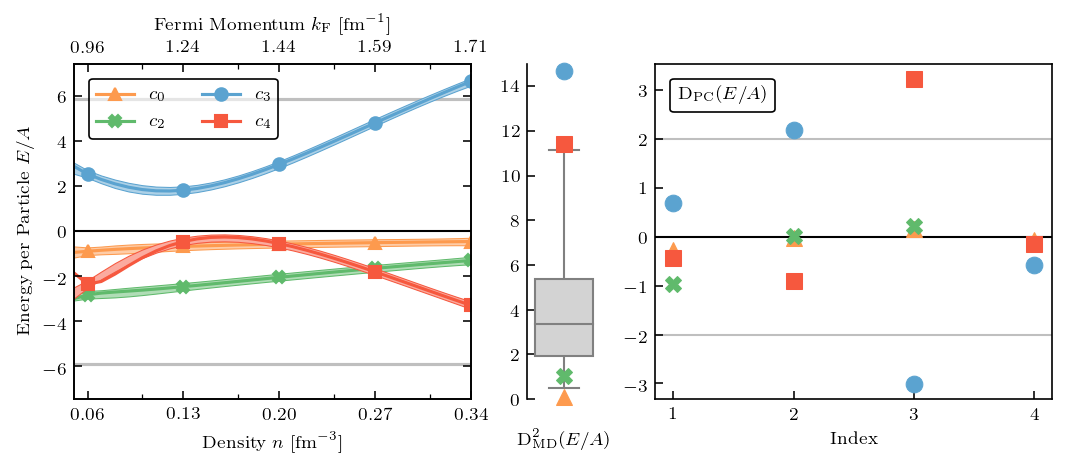

In [61]:
# Generate Figure 17 
fig = plt.figure(figsize=(7, 3))
fig = analysis_s.plot_coeff_diagnostics(
    breakdown=Lb, show_excluded=True, fig=fig
#     kernel=RBF(length_scale=0.466)+WhiteKernel(1e-5, 'fixed')
)

In [62]:
# fig = analysis_s.plot_coeff_diagnostics(breakdown=lb_map)

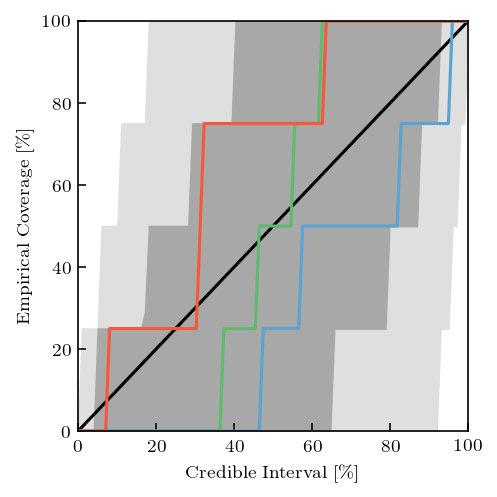

In [63]:
analysis_s.plot_credible_diagnostic(breakdown=Lb, savefig=False);

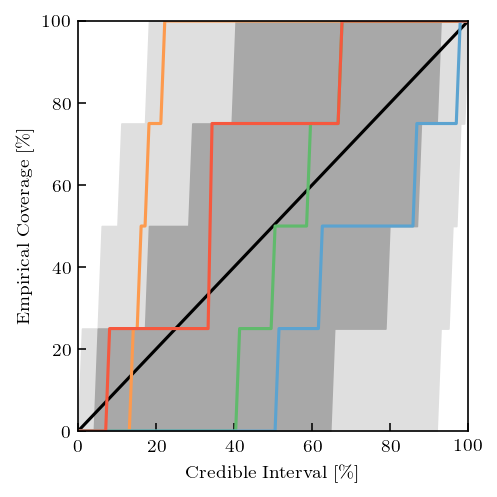

In [64]:
analysis_s.plot_credible_diagnostic(breakdown=Lb, show_excluded=True, savefig=False);

In [65]:
order_labels = ['LO', 'NLO', 'N$^2$LO', 'N$^3$LO']

In [66]:
color_list = ['Oranges', 'Greens', 'Blues', 'Reds', 'Purples', 'Greys']
cmaps = [plt.get_cmap(name) for name in color_list[:len(orders)]]
colors = [cmap(0.55 - 0.1 * (i == 0)) for i, cmap in enumerate(cmaps)]
light_colors = [lighten_color(color) for color in colors]
dark_colors = [darken_color(color) for color in colors]

/Users/furnstah/anaconda3/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


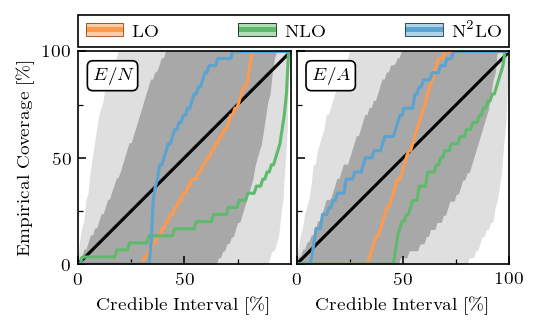

In [67]:
# Generate Figure 8

fig, axes = plt.subplots(1, 2, figsize=(3.4, 2.05), sharey=True)
# fig.set_constrained_layout_pads(h_pad=1.1/72, w_pad=0.5/72)
fig.set_constrained_layout_pads(h_pad=1.1/72, w_pad=0.3/72)

analysis_n.plot_credible_diagnostic(
    breakdown=Lb, truncation=True, show_excluded=True, all_points=True,
    ax=axes[0], show_legend=False, savefig=False
);
analysis_s.plot_credible_diagnostic(
    breakdown=Lb, truncation=True, show_excluded=True, all_points=True,
    ax=axes[1], show_legend=False, ylabel=None, savefig=False
);
# axes[0].set_xticks(axes[0].get_xticks()[:-1])
axes[0].text(
    0.07, 0.93, r'$E/N$', transform=axes[0].transAxes,
    ha='left', va='top',
    bbox=dict(boxstyle='round', facecolor='w'),
)
axes[1].text(
    0.07, 0.93, r'$E/A$', transform=axes[1].transAxes,
    ha='left', va='top',
    bbox=dict(boxstyle='round', facecolor='w')
)
axes[0].set_xticks([0, .50])
axes[0].set_xticklabels([0, 50])
axes[0].set_xticks([.25, .75], minor=True)
axes[1].set_xticks([0, 0.50, 1.00])
axes[1].set_xticklabels([0, 50, 100])
axes[1].set_xticks([.25, .75], minor=True)
axes[0].set_aspect(1)
axes[1].set_aspect(1)
for ax in axes.ravel():
    ax.set_yticks([0, 0.50, 1.00])
    ax.set_yticklabels([0, 50, 100])
    ax.set_yticks([0.25, 0.75], minor=True)
    
add_top_order_legend(fig, axes[0], axes[1], order_labels[:-1], colors, light_colors, dark_colors)
fig.savefig(join(fig_path, f'both_pnm_snm_ci_diagnostics_lambda-{Lambda}'))
plt.show()


In [68]:
# fig = analysis_s.plot_coeff_diagnostics(breakdown=None)

[0 2 3 4]


/Users/furnstah/anaconda3/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


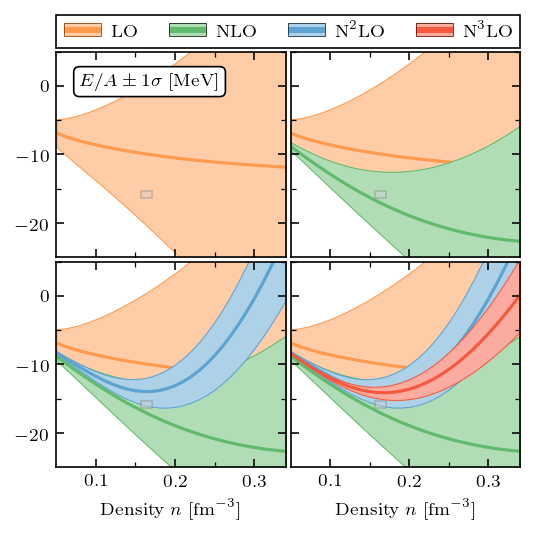

In [69]:
# Generate figure 7

# fig, ax = plt.subplots(1,1, figsize=(3.4, 3.4))
# axes = np.atleast_2d(ax)
fig, axes = plt.subplots(2, 2, figsize=(3.4, 3.4), sharex=True, sharey=True)
fig.set_constrained_layout_pads(h_pad=1.1/72, w_pad=1.2/72)
obs_label = r"""$E/A \pm 1\sigma$ [MeV]"""
axes[0,0].text(
    0.1, 0.9, obs_label, transform=axes[0,0].transAxes, ha='left', va='top',
    bbox=dict(boxstyle='round', facecolor='w')
)
for ax in axes.ravel():
    ax.set_ylim(-25, 5)
analysis_s.plot_observables(breakdown=Lb, show_process=True, show_excluded=True, ax=axes, panels=True)
plt.show()

In [70]:
n_samples = 3000

if high_density:
    kf_s_dense = np.linspace(kf_s[3:].min(), kf_s[:].max(), 150)
    sat_conditioned = slice(None, None, 4)
else:
    kf_s_dense = np.linspace(kf_s.min(), kf_s.max(), 100)
    sat_conditioned = slice(None, None, 2)
Kf_s_dense = kf_s_dense[:, None]

# The points to fit the GP to (but hyperparameter training is still at "train")


In [71]:
lb_map

537.0

In [72]:
Lambda

500

RBF(length_scale=0.485) + WhiteKernel(noise_level=0.0005)
Order 3
x: 0.16636803516346169 +/- 0.023426561245188264
y: -14.31709724596023 +/- 2.2051343698177672
mean:
 [  0.16636804 -14.31709725]
cov:
 [[ 5.48986767e-04 -4.65415265e-02]
 [-4.65415265e-02  4.86423900e+00]]
RBF(length_scale=0.485) + WhiteKernel(noise_level=0.0005)
Order 4
x: 0.17014641892624802 +/- 0.016306657383554697
y: -14.295085167152896 +/- 1.0127147317608916
mean:
 [  0.17014642 -14.29508517]
cov:
 [[ 2.65995740e-04 -1.51501305e-02]
 [-1.51501305e-02  1.02593311e+00]]
manuscript_figures/sat_ellipse_ords-3-4_sys-s_NN+3N_fit-4-10_Lamb-500_Q-kf_Lb-600_ls-x_midx-x_hyp-0-0-10-0p8


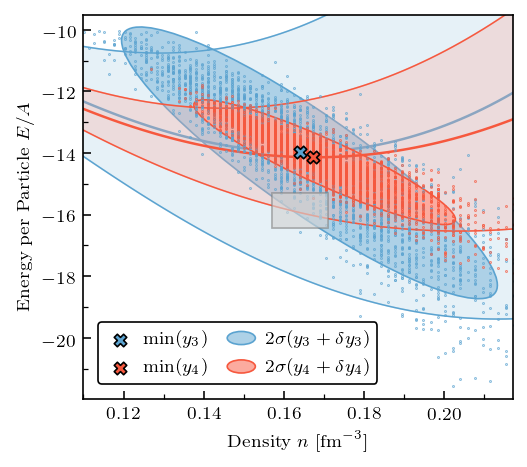

In [73]:
# Generate Figure 73 (also figures ...)

fig, ax = plt.subplots(1, 1, figsize=(3.4, 3))
np.random.seed(1)

ax.set_xlim(0.11, 0.217)
ax.set_ylim(-21.99, -9.5)
# if Lambda == 500:
#     ax.set_ylim(-19.3, -10.1)
# elif Lambda == 450:
#     ax.set_ylim(-21, -10.1)
ax.yaxis.set_major_locator(MultipleLocator(2))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
analysis_s.plot_multi_saturation(
    breakdown=Lb, orders=[3,4], nugget=1e-5, X=Kf_s_dense,
    cond=sat_conditioned, n_samples=n_samples, ax=ax, savefig=True,
    is_density_primary=True,
    legend_kwargs=dict(ncol=2, columnspacing=1, handletextpad=0.5, handlelength=1.5, loc='lower left'),
);
# ax.set_xlim(None, 0.22)
# ax.set_ylim(-20, -10)


In [74]:
# fig, ax = plt.subplots(1, 1, figsize=(4, 3.4))
# np.random.seed(1)
# analysis_s.plot_multi_saturation(
#     breakdown=Lb, orders=[3,4], nugget=1e-6, X=Kf_s,
#     cond=train,
#     n_samples=n_samples, ax=ax, savefig=False
# );

In [75]:
# fig, ax = plt.subplots(1, 1, figsize=(4, 3.4))
# np.random.seed(1)
# analysis_s.plot_multi_saturation(
#     breakdown=320., orders=[3,4], nugget=1e-5, X=Kf_s,
#     cond=train,
#     n_samples=n_samples, ax=ax, savefig=False
# );

In [76]:
# fig, ax = plt.subplots(1, 1, figsize=(4, 3.4))
# np.random.seed(1)
# analysis_s.plot_multi_saturation(
#     orders=[3,4], nugget=1e-5, X=Kf_s_dense,
#     cond=sat_conditioned, n_samples=n_samples, ax=ax, savefig=True
# );

## Symmetry Energy  \[Figures 10, 11, 12 and SM 6, 7\] <a id="symmetry_energy"></a> 



In [77]:
from nuclear_matter.stats_utils import create_truncation_multi_covariance, create_rbf_multi_covariance, \
    create_sym_energy_rbf_covariance, create_sym_energy_truncation_covariance

In [78]:
def plot_cross_covariance(x, cov, label1=r'$E/A$', label2=r'$E/N$', ax=None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots(figsize=(3.4, 3.4))
    # ax.contourf(x_test_twice, x_test_twice[::-1], cov_test, levels=100)
    x = x - x[0]
    x_max = x[-1]
    x_min = x[0]
    ax.imshow(
        cov, origin='upper', interpolation='bilinear', cmap='cividis',
        extent=(x_min, 2*x_max, x_min, 2*x_max), **kwargs
    )
#     ax.pcolormesh(
#         cov,
# #         origin='upper', interpolation='bilinear', cmap='cividis',
# #         extent=(x_min, 2*x_max, x_min, 2*x_max)
#     )
    ax.axhline(x_max, 0, 1, c='k', lw=0.8)
    ax.axvline(x_max, 0, 1, c='k', lw=0.8)
    ax.set_xticks([x_max/2, 3 * x_max / 2])
    ax.set_xticklabels([label1, label2])
    ax.set_yticks([x_max/2, 3 * x_max / 2])
    ax.set_yticklabels([label2, label1])
#     x_labels = x[::6]
#     ax.set_yticks(np.arange(len(x_labels)))
# #     ax.set_yticks(x_labels)
# #     ax.set_yticklabels(x_labels)
#     ax.set_xticks(np.arange(len(x_labels)))
# #     ax.set_xticks(x_labels)
# #     ax.set_xticklabels(x_labels)
    ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False, width=0)
    return ax

In [79]:
from nuclear_matter.stats_utils import cov_no_centering, CorrKernel

In [80]:
en_true_coeffs = analysis_n.compute_coefficients(breakdown=Lb, show_excluded=True)
ea_true_coeffs = analysis_s.compute_coefficients(breakdown=Lb, show_excluded=True)
c_both_flat = np.stack((en_true_coeffs[:, 1:].ravel(), ea_true_coeffs[:, 1:].ravel()), axis=0).T
cov_en_ea_empirical = cov_no_centering(*c_both_flat.T)

In [81]:
rho_empirical = cov_en_ea_empirical[1, 0] / np.sqrt(cov_en_ea_empirical[0, 0] * cov_en_ea_empirical[1, 1])

In [82]:
cbar_n, kern_fit_n = analysis_n.compute_std_and_kernel(breakdown=Lb)
cbar_s, kern_fit_s = analysis_s.compute_std_and_kernel(breakdown=Lb)

ls_n = kern_fit_n.k1.get_params()['length_scale']
ls_s = kern_fit_s.k1.get_params()['length_scale']

# TESTING:
# cbar_s = cbar_n
# ls_s = ls_n

print('cbar_n', cbar_n, 'ls_n', ls_n)
print('cbar_s', cbar_s, 'ls_s', ls_s)

kf_conversion_factor = 2 ** (1/3.)
ls_s_scaled = kf_conversion_factor * ls_s

# rho_corr = np.sqrt(2 * ls_n * ls_s / (ls_n**2 + ls_s**2))

print(np.sqrt(2 * ls_n * ls_s_scaled / (ls_n**2 + ls_s_scaled**2)))


if Lambda == 450:
    rho_sym_energy = rho_corr = rho_empirical
    ls1 = (ls_s + ls_n) / 2
    ls2 = None
else:
    rho_sym_energy = None
    rho_corr = np.sqrt(2 * ls_n * ls_s_scaled / (ls_n**2 + ls_s_scaled**2))
    ls1 = ls_n
    ls2 = ls_s_scaled


print('rho', rho_corr, rho_sym_energy)
    
kf_n_linear = np.linspace(kf_n[0], kf_n[-1], len(kf_n))
kf_s_linear = np.linspace(kf_s[0], kf_s[-1], len(kf_s))
Kf_n_linear = kf_n_linear[:, None]
Kf_s_linear = kf_s_linear[:, None]

kf_linear = np.linspace(0, 2, 101)
Kf_linear = kf_linear[:, None]

K_multi_ns = create_truncation_multi_covariance(
    Kf_n, Kf_s, cbar_n, cbar_s, ls1, ls2,
    ref_2bf_func_n(Kf_n), ref_2bf_func_s(Kf_s),
    ratio_kf(Kf_n, breakdown=Lb), ratio_kf(Kf_n, breakdown=Lb),
    kmin=4, nugget=1e-12, rho=rho_sym_energy
)

# This is just for show, so use same linear Kf's and cbar = 1

corr_multi_coeff_ns = create_rbf_multi_covariance(
    Kf_linear, Kf_linear, 1, 1,
    ls_n, ls_s_scaled,
    nugget=1e-13, rho=rho_sym_energy
)
K_multi_coeff_ns = create_rbf_multi_covariance(
    Kf_n, Kf_s, cbar_n, cbar_s, ls1, ls2, nugget=1e-10,
    rho=rho_sym_energy
)
K_d_coeff = create_sym_energy_rbf_covariance(
    density, cbar_n, cbar_s, ls1, ls2, nugget=1e-15,
    rho=rho_sym_energy
)
corr_d_coeff = create_sym_energy_rbf_covariance(
    density, 1, 1, ls1, ls2, nugget=1e-15, rho=rho_sym_energy
)

std_d_truncs = {}
std_d_truncs_no_corr = {}
for i, n in enumerate(orders):
    kmin = n+1 if n != 0 else 2
    
    K_d_trunc = create_sym_energy_truncation_covariance(
        density, cbar_n, cbar_s, ls1, ls2,
        ref_2bf_func_n(Kf_n), ref_2bf_func_s(Kf_s),
        ratio_kf(Kf_n, breakdown=Lb), ratio_kf(Kf_s, breakdown=Lb),
        kmin=kmin, nugget=1e-10, rho=rho_sym_energy
    )
    std_d_trunc = np.sqrt(np.diag(K_d_trunc))
    std_d_truncs[n] = std_d_trunc
    
    K_d_trunc_no_corr = create_sym_energy_truncation_covariance(
        density, cbar_n, cbar_s, ls1, ls2,
        ref_2bf_func_n(Kf_n), ref_2bf_func_s(Kf_s),
        ratio_kf(Kf_n, breakdown=Lb), ratio_kf(Kf_s, breakdown=Lb),
        kmin=kmin, nugget=1e-10, rho=rho_sym_energy, ignore_corr=True
    )
    std_d_trunc_no_corr = np.sqrt(np.diag(K_d_trunc_no_corr))
    std_d_truncs_no_corr[n] = std_d_trunc_no_corr

cbar_n 1.0013486060408017 ls_n 0.9731398181235958
cbar_s 2.9476905416196773 ls_s 0.4846364734101784
0.948903443853753
rho 0.948903443853753 None


In [83]:
std_d_truncs_no_corr[4] / std_d_truncs[4]

array([7.25427096, 7.16896944, 7.08560201, 7.00302479, 6.92014533,
       6.84051252, 6.75916173, 6.67888229, 6.59934499, 6.5195733 ,
       6.4403805 , 6.36184031, 6.28259284, 6.20513402, 6.12636825,
       6.04813754, 5.9711731 , 5.89352098, 5.81548181, 5.73892919,
       5.66157896, 5.58570856, 5.50912789, 5.43311874, 5.35741726,
       5.28189035, 5.20630601, 5.13108991, 5.05651672, 4.98222638])

In [84]:
std_d_truncs_no_corr[3] / std_d_truncs[3]

array([6.839269  , 6.9247555 , 7.00826468, 7.09087018, 7.17355498,
       7.25327278, 7.33426781, 7.41408632, 7.49293606, 7.5715445 ,
       7.64908362, 7.72533812, 7.80125238, 7.87455035, 7.94750856,
       8.01833775, 8.08619099, 8.15221124, 8.21572513, 8.27502505,
       8.33119343, 8.38233146, 8.42922252, 8.47059711, 8.50605271,
       8.53506903, 8.55709491, 8.57141422, 8.57747812, 8.57482783])

In [85]:
from sklearn.gaussian_process import GaussianProcessRegressor

In [86]:
print(ls_n, ls_s_scaled)

0.9731398181235958 0.6106036943963008


In [87]:
y_n_2_plus_3bf.shape

(30, 4)

In [88]:
y_both_2_plus_3bf = np.concatenate((y_n_2_plus_3bf, y_s_2_plus_3bf))

In [89]:
y_both_2_plus_3bf.shape

(60, 4)

In [90]:
kf_n_twice = np.concatenate((kf_n, kf_n))
kf_n_linear_twice = np.concatenate((kf_n_linear, kf_n_linear))

In [91]:
kf_n_twice.shape

(60,)

In [92]:
kf_n_twice

array([1.13972, 1.21113, 1.27499, 1.33302, 1.3864 , 1.43595, 1.48231,
       1.52593, 1.56719, 1.60639, 1.64376, 1.6795 , 1.71379, 1.74675,
       1.77852, 1.80919, 1.83885, 1.86759, 1.89547, 1.92255, 1.94889,
       1.97453, 1.99953, 2.02392, 2.04773, 2.071  , 2.09376, 2.11604,
       2.13786, 2.15924, 1.13972, 1.21113, 1.27499, 1.33302, 1.3864 ,
       1.43595, 1.48231, 1.52593, 1.56719, 1.60639, 1.64376, 1.6795 ,
       1.71379, 1.74675, 1.77852, 1.80919, 1.83885, 1.86759, 1.89547,
       1.92255, 1.94889, 1.97453, 1.99953, 2.02392, 2.04773, 2.071  ,
       2.09376, 2.11604, 2.13786, 2.15924])

In [93]:
RBF(0.6, (0.1, 3))(kf_n)

array([[1.]])

In [94]:
# coregional_kernel = CorrKernel(0.5, (0.2, 1), std1=cbar_n, std2=cbar_s) * RBF(0.6, (0.1, 3))
# coregional_kernel = CorrKernel(0.95, (0.5, 1)) * RBF(0.6, (0.4, 1.0))# + WhiteKernel(nugget/2)
# coregional_kernel = CorrKernel(0.95, (0.5, 1), std1=cbar_n, std2=cbar_s) * RBF((ls_n + ls_s) / 2, 'fixed')
coregional_kernel = CorrKernel(0.85, (0.5, 1), std1=cbar_n, std2=cbar_s) * RBF(0.6, (0.1, 3))

In [95]:
gp_coregion = GaussianProcessRegressor(coregional_kernel, alpha=1e-10, n_restarts_optimizer=5)

In [96]:
c_both_2_plus_3bf = np.concatenate((
    analysis_n.compute_coefficients(breakdown=Lb),
    analysis_s.compute_coefficients(breakdown=Lb)
))

In [97]:
# plt.plot(kf_n_twice, c_both_2_plus_3bf)

In [98]:
gp_coregion.fit(kf_n_twice[:, None], c_both_2_plus_3bf)

/Users/furnstah/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=CorrKernel(rho=0.85) * RBF(length_scale=0.6),
                         n_restarts_optimizer=5, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=None)

In [99]:
gp_coregion.kernel_

CorrKernel(rho=0.5) * RBF(length_scale=0.222)

In [100]:
kf_n

array([1.13972, 1.21113, 1.27499, 1.33302, 1.3864 , 1.43595, 1.48231,
       1.52593, 1.56719, 1.60639, 1.64376, 1.6795 , 1.71379, 1.74675,
       1.77852, 1.80919, 1.83885, 1.86759, 1.89547, 1.92255, 1.94889,
       1.97453, 1.99953, 2.02392, 2.04773, 2.071  , 2.09376, 2.11604,
       2.13786, 2.15924])

/Users/furnstah/anaconda3/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


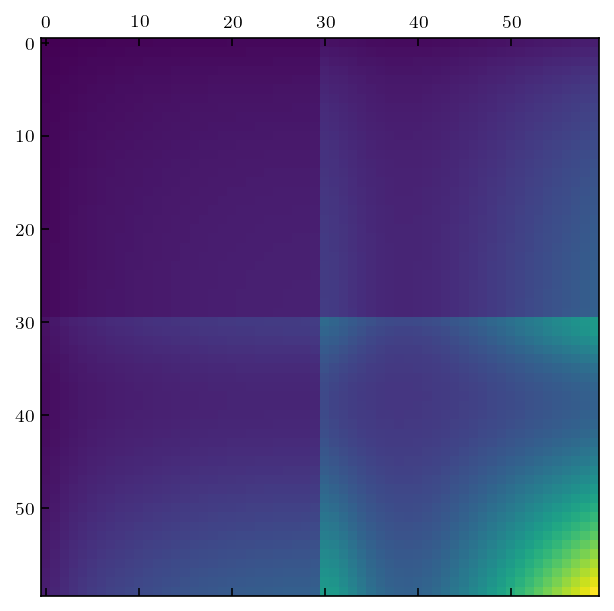

In [101]:
plt.matshow(np.cov(c_both_2_plus_3bf))

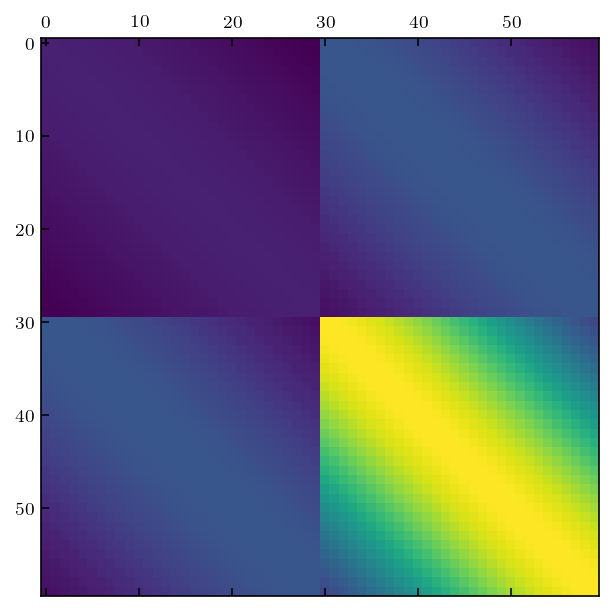

In [102]:
plt.matshow(coregional_kernel(kf_n_linear_twice[:, None]))

In [103]:
coregional_kernel.hyperparameters

[Hyperparameter(name='k1__rho', value_type='numeric', bounds=array([[0.5, 1. ]]), n_elements=1, fixed=False),
 Hyperparameter(name='k2__length_scale', value_type='numeric', bounds=array([[0.1, 3. ]]), n_elements=1, fixed=False)]

In [104]:
coregional_kernel.hyperparameters

[Hyperparameter(name='k1__rho', value_type='numeric', bounds=array([[0.5, 1. ]]), n_elements=1, fixed=False),
 Hyperparameter(name='k2__length_scale', value_type='numeric', bounds=array([[0.1, 3. ]]), n_elements=1, fixed=False)]

In [105]:
coregional_kernel(kf_n_twice[:, None])

array([[1.00269903, 0.99562252, 0.97753766, ..., 0.66761798, 0.62884136,
        0.59227184],
       [0.99562252, 1.00269903, 0.99703577, ..., 0.80456162, 0.76111822,
        0.71990291],
       [0.97753766, 0.99703577, 1.00269903, ..., 0.93931841, 0.89204472,
        0.84694564],
       ...,
       [0.66761798, 0.80456162, 0.93931841, ..., 8.68887953, 8.68313576,
        8.66638712],
       [0.62884136, 0.76111822, 0.89204472, ..., 8.68313576, 8.68887953,
        8.683365  ],
       [0.59227184, 0.71990291, 0.84694564, ..., 8.66638712, 8.683365  ,
        8.68887953]])

In [106]:
kf_s * kf_conversion_factor

array([1.13971198, 1.21112431, 1.27498971, 1.33302167, 1.38639192,
       1.43595722, 1.48230971, 1.52592818, 1.5671906 , 1.60638674,
       1.643756  , 1.67949996, 1.71378241, 1.74675454, 1.77851715,
       1.80918363, 1.83885477, 1.86759357, 1.89546303, 1.92255133,
       1.94888368, 1.97453567, 1.9995325 , 2.02392458, 2.04773708,
       2.07100782, 2.093762  , 2.1160374 , 2.13785924, 2.1592401 ])

In [107]:
np.concatenate((kf_n, kf_s))

array([1.13972, 1.21113, 1.27499, 1.33302, 1.3864 , 1.43595, 1.48231,
       1.52593, 1.56719, 1.60639, 1.64376, 1.6795 , 1.71379, 1.74675,
       1.77852, 1.80919, 1.83885, 1.86759, 1.89547, 1.92255, 1.94889,
       1.97453, 1.99953, 2.02392, 2.04773, 2.071  , 2.09376, 2.11604,
       2.13786, 2.15924, 0.90459, 0.96127, 1.01196, 1.05802, 1.10038,
       1.13972, 1.17651, 1.21113, 1.24388, 1.27499, 1.30465, 1.33302,
       1.36023, 1.3864 , 1.41161, 1.43595, 1.4595 , 1.48231, 1.50443,
       1.52593, 1.54683, 1.56719, 1.58703, 1.60639, 1.62529, 1.64376,
       1.66182, 1.6795 , 1.69682, 1.71379])

In [108]:
2 ** (1./3)

1.2599210498948732

In [109]:
np.diag(K_d_coeff) / (cbar_s)

array([1.31237694, 1.31237694, 1.31237694, 1.31237694, 1.31237694,
       1.31237694, 1.31237694, 1.31237694, 1.31237694, 1.31237694,
       1.31237694, 1.31237694, 1.31237694, 1.31237694, 1.31237694,
       1.31237694, 1.31237694, 1.31237694, 1.31237694, 1.31237694,
       1.31237694, 1.31237694, 1.31237694, 1.31237694, 1.31237694,
       1.31237694, 1.31237694, 1.31237694, 1.31237694, 1.31237694])

In [110]:
cbar_n, cbar_s, np.sqrt(np.diag(K_d_coeff) / (cbar_n))

(1.0013486060408017,
 2.9476905416196773,
 array([1.96552056, 1.96552056, 1.96552056, 1.96552056, 1.96552056,
        1.96552056, 1.96552056, 1.96552056, 1.96552056, 1.96552056,
        1.96552056, 1.96552056, 1.96552056, 1.96552056, 1.96552056,
        1.96552056, 1.96552056, 1.96552056, 1.96552056, 1.96552056,
        1.96552056, 1.96552056, 1.96552056, 1.96552056, 1.96552056,
        1.96552056, 1.96552056, 1.96552056, 1.96552056, 1.96552056]))

In [111]:
np.diag(corr_d_coeff)

array([0.02718267, 0.02718267, 0.02718267, 0.02718267, 0.02718267,
       0.02718267, 0.02718267, 0.02718267, 0.02718267, 0.02718267,
       0.02718267, 0.02718267, 0.02718267, 0.02718267, 0.02718267,
       0.02718267, 0.02718267, 0.02718267, 0.02718267, 0.02718267,
       0.02718267, 0.02718267, 0.02718267, 0.02718267, 0.02718267,
       0.02718267, 0.02718267, 0.02718267, 0.02718267, 0.02718267])

In [112]:
np.sqrt(np.diag(corr_d_coeff))

array([0.16487169, 0.16487169, 0.16487169, 0.16487169, 0.16487169,
       0.16487169, 0.16487169, 0.16487169, 0.16487169, 0.16487169,
       0.16487169, 0.16487169, 0.16487169, 0.16487169, 0.16487169,
       0.16487169, 0.16487169, 0.16487169, 0.16487169, 0.16487169,
       0.16487169, 0.16487169, 0.16487169, 0.16487169, 0.16487169,
       0.16487169, 0.16487169, 0.16487169, 0.16487169, 0.16487169])

/Users/furnstah/anaconda3/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


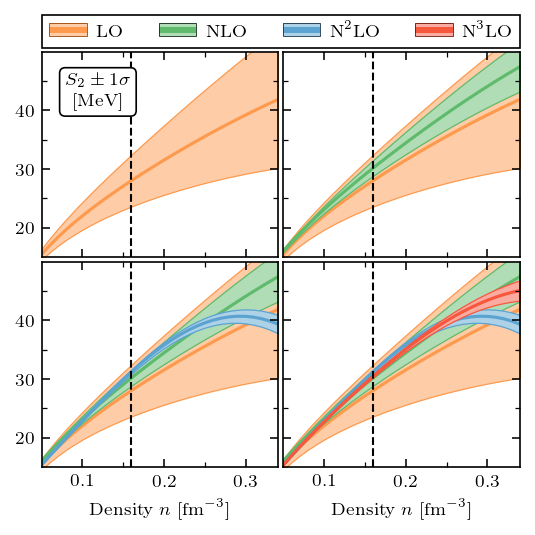

In [113]:
# Generate figure 12 

with plt.rc_context({"text.usetex": True, "text.latex.preview": True}):
    fig, axes = plt.subplots(2, 2, figsize=(3.4, 3.4), sharex=True, sharey=True)
    for j in range(len(orders)):
        ax = axes.ravel()[j]
        ax.axvline(0.16, 0, 1, c='k', ls='--', lw=1, zorder=3)
        ax.set_ylim(15, 49.999)
        ax.set_xlim(density[0], density[-1])
        ax.tick_params(right=True, top=True, which='both')
        ax.xaxis.set_minor_locator(AutoMinorLocator(2))
        ax.yaxis.set_minor_locator(AutoMinorLocator(2))

        for i, n in enumerate(orders[:j+1]):
            ax.plot(density, y_d_2_plus_3bf[:, i], c=colors[i], zorder=i/10)
            std_d_trunc = std_d_truncs[n]
            ax.fill_between(
                density, y_d_2_plus_3bf[:, i] + std_d_trunc,
                y_d_2_plus_3bf[:, i] - std_d_trunc,
                facecolor=lighten_color(colors[i]), edgecolor=colors[i],
                lw=0.6, zorder=i/10
            )
    fig.set_constrained_layout_pads(h_pad=1.1/72, w_pad=1.2/72)
    axes[1, 0].set_xlabel('Density $n$ [fm$^{-3}$]')
    axes[1, 1].set_xlabel('Density $n$ [fm$^{-3}$]')
    label = r"""$S_2 \pm 1\sigma$
    [MeV]"""
    axes[0, 0].text(
        0.1, 0.9, label, transform=axes[0,0].transAxes, ha='left', va='top',
        multialignment='center',
        bbox=dict(facecolor='w', boxstyle='round')
    )
    add_top_order_legend(fig, axes[0, 0], axes[0, 1], order_labels, colors, light_colors, dark_colors)
    fig.savefig(path.join(fig_path, f'S2_order-by-order-Lambda-{Lambda}'))
    plt.show()



In [114]:
from matplotlib.colors import LogNorm

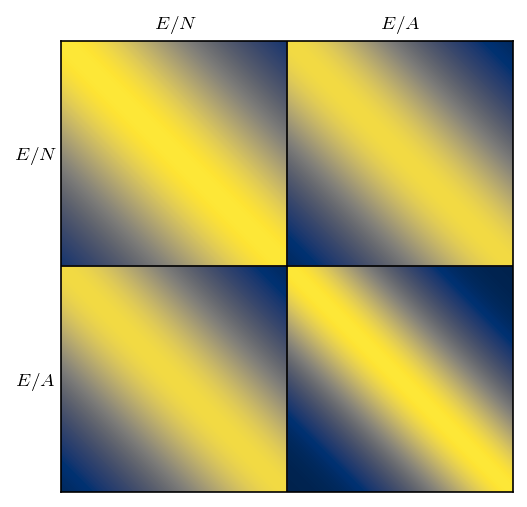

In [115]:
# Generate Figure 11

ax = plot_cross_covariance(density, corr_multi_coeff_ns, label1=r'$E/N$', label2=r'$E/A$')
fig = plt.gcf()
fig.savefig(path.join(fig_path, f'EN_EA_full_correlation_matrix_Lambda-{Lambda}'))

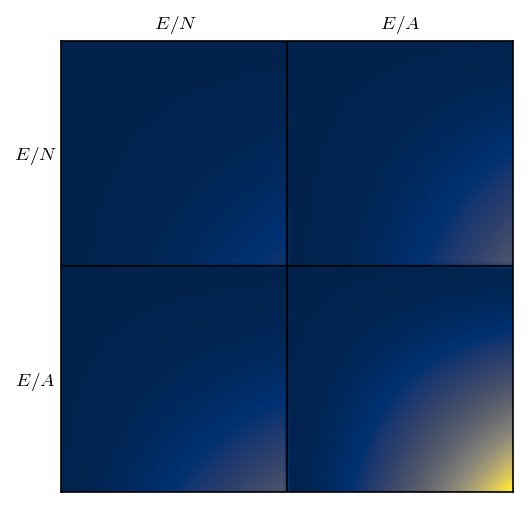

In [116]:
plot_cross_covariance(density, K_multi_ns, label1=r'$E/N$', label2=r'$E/A$')

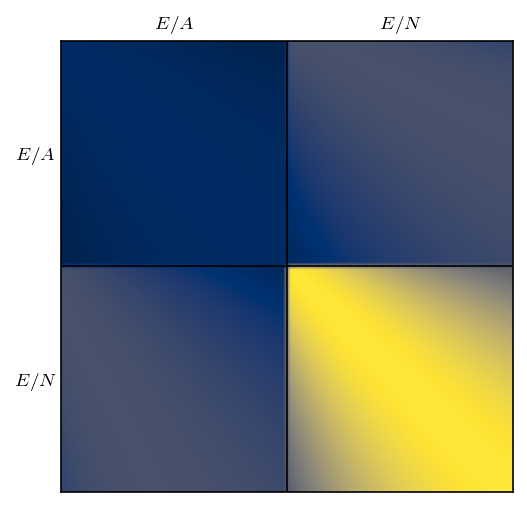

In [117]:
plot_cross_covariance(density, K_multi_coeff_ns)

In [118]:
n_coeff_samples = 10
np.random.seed(1)
en_ea_coeff_samples = stats.multivariate_normal(
    mean=np.zeros(2*density.shape[0]), cov=K_multi_coeff_ns, allow_singular=True).rvs(n_coeff_samples).T
en_coeff_samples = en_ea_coeff_samples[:density.shape[0]]
ea_coeff_samples = en_ea_coeff_samples[density.shape[0]:]

mean_samples = np.zeros(2)


cov_samples = np.array([
    [cbar_n**2, cbar_n * cbar_s * rho_corr],
    [cbar_n * cbar_s * rho_corr, cbar_s**2]
])

In [119]:
print('rho empirical:', rho_empirical)
print('rho coregional:', rho_corr)

rho empirical: 0.943315508403965
rho coregional: 0.948903443853753


In [120]:
print('std empirical:')
print('   E/N', np.sqrt(cov_en_ea_empirical[0, 0]))
print('   E/A', np.sqrt(cov_en_ea_empirical[1, 1]))

print('std coregional:')
print('   E/N', cbar_n)
print('   E/A', cbar_s)

std empirical:
   E/N 1.2080540233405372
   E/A 2.73237706628434
std coregional:
   E/N 1.0013486060408017
   E/A 2.9476905416196773


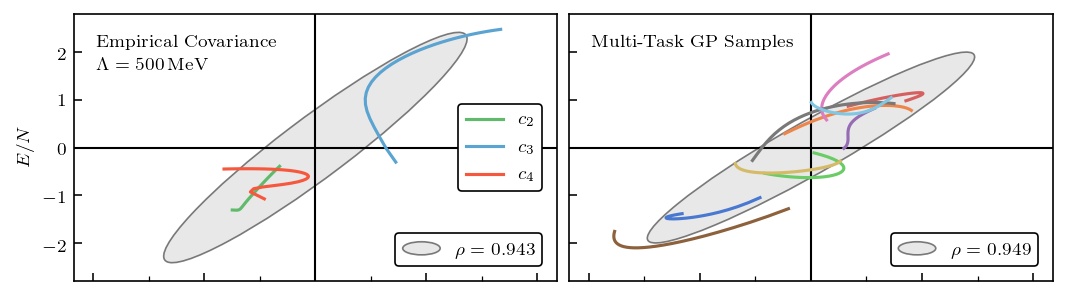

In [121]:
# Generate Figure 10

# Makes the 450 and 500 plots have the same aspect ratio,
# even though one has x-labels and the other doesn't.
# Found by trial and error
if Lambda == 450:
    fig_height = 2.2
else:
    fig_height = 1.863

fig, axes = plt.subplots(1, 2, figsize=(7, fig_height), sharex=True, sharey=True)


ellipse_label_empirical = fr'$\rho = {rho_empirical:0.3f}$'
ellipse_emp = confidence_ellipse_mean_cov(
    mean_samples, cov_en_ea_empirical[::-1, ::-1], axes[0], n_std=2,
    facecolor='lightgrey', edgecolor='k', alpha=0.5, zorder=-2,
#     label=ellipse_label_empirical
)

# Create a legend for the ellipse.
first_legend = axes[0].legend(handles=[ellipse_emp], labels=[ellipse_label_empirical], loc='lower right')

# Add the legend manually to the current Axes.
axes[0].add_artist(first_legend)

# axes[0].text(
#     0.24, 0.92, ellipse_label_empirical, transform=axes[0].transAxes,
#     ha='left', va='top', bbox=dict(boxstyle='round', facecolor='w')
# )

axes[0].axhline(0, 0, 1, c='k', lw=1)
axes[0].axvline(0, 0, 1, c='k', lw=1)

for i, n in enumerate(orders):
    if n == 0:
        continue
    
    axes[0].plot(ea_true_coeffs[:, i], en_true_coeffs[:, i], c=colors[i], label=fr'$c_{{{n}}}$')

axes[0].set_ylabel(r'$E/N$')

confidence_ellipse_mean_cov(
    mean_samples, cov_samples[::-1, ::-1], axes[1], n_std=2,
    facecolor='lightgrey', edgecolor='k', alpha=0.5, zorder=-2,
    label=fr'$\rho = {rho_corr:0.3f}$'
)

axes[1].axhline(0, 0, 1, c='k', lw=1)
axes[1].axvline(0, 0, 1, c='k', lw=1)
for i in range(n_coeff_samples):
    axes[1].plot(ea_coeff_samples[:, i], en_coeff_samples[:, i], c=sns.color_palette('muted')[i])

xlim = np.max(np.abs([*axes[0].get_xlim(), *axes[1].get_xlim()]))
ylim = np.max(np.abs([*axes[0].get_ylim(), *axes[1].get_ylim()]))
for ax in axes:
    ax.set_xlim(-xlim, xlim)
    ax.set_ylim(-ylim, ylim)

# axes[0].set_aspect(1.5)
# axes[1].set_aspect(1.5)
axes[0].legend(loc='right', framealpha=1)
axes[0].text(
    0.045, 0.93, f'Empirical Covariance\n $\Lambda = {Lambda}$\,MeV', transform=axes[0].transAxes,
    ha='left', va='top', multialignment='left', linespacing=1.6
)

# axes[0].text(
#     0.97, 0.225, fr'$\Lambda = {Lambda}$\,MeV', transform=axes[0].transAxes,
#     ha='right', va='bottom',
# )


axes[1].text(
    0.045, 0.93, 'Multi-Task GP Samples', transform=axes[1].transAxes,
    ha='left', va='top',
#     bbox=dict(boxstyle='round', facecolor='w')
)
axes[1].legend(loc='lower right')


if Lambda == 450:
    axes[0].set_xlabel(r'$E/A$')
    axes[1].set_xlabel(r'$E/A$')
else:
    axes[0].set_xticklabels([''])
    axes[1].set_xticklabels([''])

axes[0].set_xlim(-8.7, 8.7)
axes[0].set_ylim(-2.8, 2.8)
axes[0].xaxis.set_major_locator(MultipleLocator(4))
axes[0].xaxis.set_minor_locator(AutoMinorLocator(2))

# fig.tight_layout()

fig.savefig(path.join(fig_path, f'empirical_correlation_ellipses_coefficients_Lambda-{Lambda}'))


In [122]:
K_multi_ns

array([[2.46776180e-02, 3.58200341e-02, 4.89185451e-02, ...,
        2.92299956e+00, 3.09442259e+00, 3.26966480e+00],
       [3.58200341e-02, 5.22741924e-02, 7.17341894e-02, ...,
        4.49272526e+00, 4.76512929e+00, 5.04424073e+00],
       [4.89185451e-02, 7.17341894e-02, 9.88633389e-02, ...,
        6.44504348e+00, 6.84728772e+00, 7.26027183e+00],
       ...,
       [2.92299956e+00, 4.49272526e+00, 6.44504348e+00, ...,
        5.97938667e+02, 6.41924722e+02, 6.87407189e+02],
       [3.09442259e+00, 4.76512929e+00, 6.84728772e+00, ...,
        6.41924722e+02, 6.89701221e+02, 7.39151278e+02],
       [3.26966480e+00, 5.04424073e+00, 7.26027183e+00, ...,
        6.87407189e+02, 7.39151278e+02, 7.92758890e+02]])

In [123]:
np.linalg.eigh(K_multi_ns)

(array([7.62576753e-13, 8.54771757e-13, 9.19617289e-13, 9.31218816e-13,
        9.45938740e-13, 9.53665548e-13, 9.67857043e-13, 9.68411537e-13,
        9.82483955e-13, 9.87733017e-13, 9.88685321e-13, 9.92886679e-13,
        9.93519230e-13, 9.94153963e-13, 9.94631836e-13, 9.94931877e-13,
        9.96743103e-13, 9.97963418e-13, 9.98848118e-13, 9.99065310e-13,
        9.99185879e-13, 9.99530039e-13, 9.99853772e-13, 1.00014300e-12,
        1.00053620e-12, 1.00122434e-12, 1.00176861e-12, 1.00220777e-12,
        1.00278843e-12, 1.00418468e-12, 1.00528819e-12, 1.00821737e-12,
        1.00921733e-12, 1.01167205e-12, 1.02141784e-12, 1.02585498e-12,
        1.02873712e-12, 1.04409445e-12, 1.04639196e-12, 1.06874922e-12,
        1.10173809e-12, 1.14068750e-12, 1.18205352e-12, 1.80405144e-12,
        2.41947998e-12, 1.25970702e-11, 4.00718687e-10, 1.91764028e-09,
        2.86736312e-08, 3.99291883e-07, 7.98317592e-06, 2.07000418e-05,
        3.54367482e-04, 5.12460257e-03, 7.64898898e-02, 1.122662

RBF(length_scale=0.492) + WhiteKernel(noise_level=0.0005)
cbar mean: 1.8077640131822905


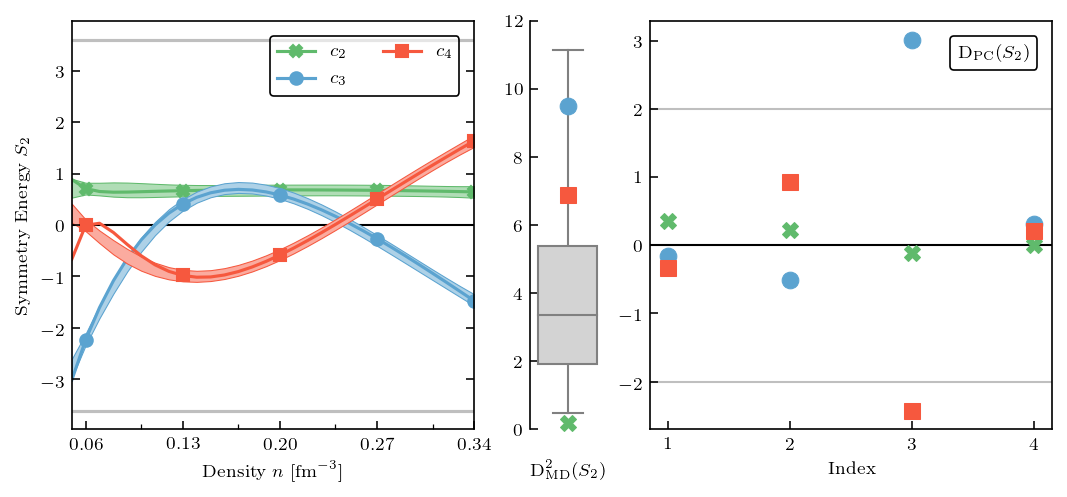

In [124]:
fig = analysis_d.plot_coeff_diagnostics(breakdown=Lb)

In [125]:
# fig = analysis_d.plot_coeff_diagnostics(breakdown=None)

In [126]:
# fig = analysis_d.plot_coeff_diagnostics(breakdown=lb_map)

In [127]:
# fig = analysis_d.plot_observables(breakdown=Lb, show_process=True)

In [128]:
# fig = analysis_d.plot_observables(breakdown=None, show_process=True)

In [129]:
# fig.savefig('test', metadata=dict(Keywords='??'))